In [ ]:
!nvidia-smi

Mon Jul 11 17:29:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install pretrainedmodels
!pip install efficientnet_pytorch
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-f7ev5obt
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-f7ev5obt
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116653 sha256=a3f8fced804a01620aa42b8409d899d3612903aa080a8d46a6bb80a2258e2aa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5mcbq5gq/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.5 MB

In [ ]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 32 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.1

In [ ]:
!git clone https://github.com/qubvel/segmentation_models.pytorch

Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 6.04 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (917/917), done.


In [ ]:
%cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント

Mounted at /content/gdrive


In [ ]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val') 
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  367
the number of image/label in the validation:  101
the number of image/label in the test:  233


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        plt.imshow(mask)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# **自己セグメンテーション**

loading annotations into memory...
Done (t=2.87s)
creating index...
index created!
[{'id': 6, 'name': 'non_road_seg', 'supercategory': '', 'color': '#da1e2c', 'metadata': {}, 'creator': 'bekkuzer', 'keypoint_colors': []}, {'id': 8, 'name': 'road_seg', 'supercategory': '', 'color': '#a79a9a', 'metadata': {}, 'creator': 'bekkuzer', 'keypoint_colors': []}]
The class name is None
Number of images containing all the  classes: 525
front_REC_170510_094808_27.jpg


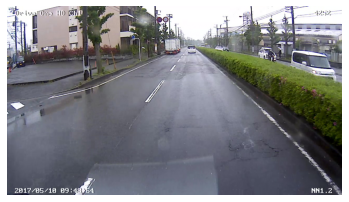

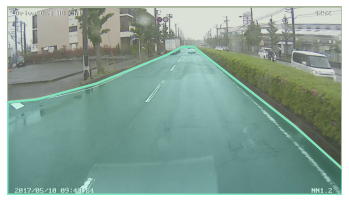

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

dataDir='/content/gdrive/MyDrive/2021_後半_GPへ向けて/10月/江戸川区-未知物体検出/路面セグメンテーション/'
annFile="/content/gdrive/MyDrive/2021_後半_GPへ向けて/10月/江戸川区-未知物体検出/路面セグメンテーション/non_road_seg_dataset.json"

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(77, cats))

# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['road_seg', 'non_road_seg']
filterClasses = ['', '']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img['file_name'])
I = io.imread('{}/non_road_seg_dataset/{}'.format(dataDir,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

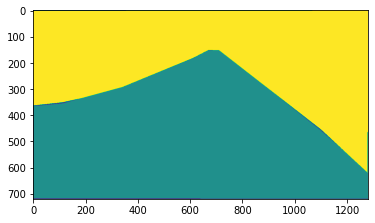

In [ ]:
filterClasses = ['road_seg', 'non_road_seg']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

maskを新しい画像として保存

In [ ]:
%mkdir mask_im

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['road_seg', 'non_road_seg']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, dsize=(608, 608))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, dsize=(608, 608))
        # plt.imshow(mask)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

# 推論

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

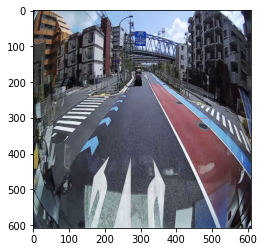

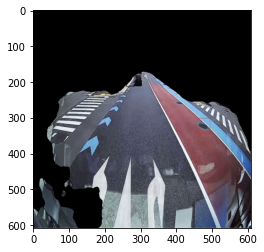

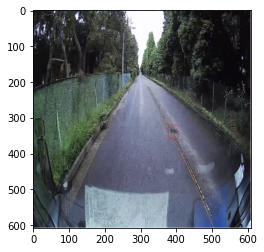

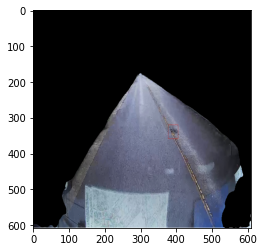

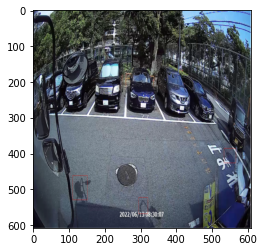

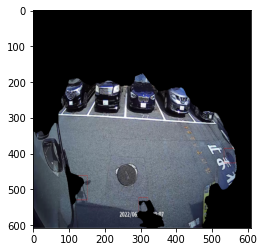

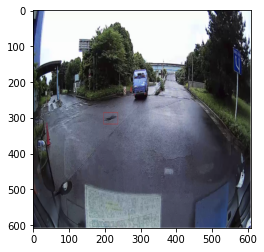

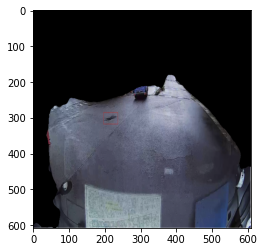

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

def imgpath_to_npimage(img_path):
  image_pil = Image.open(img_path)
  transform = transforms.Resize((608, 608))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image

img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
img_list = []
for img_path in img_paths:
    img_list.append(imgpath_to_npimage(img_path))
    img_pils.append(Image.open(img_path))
img_list = np.array(img_list)
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = Image.open(img_paths[enunum])
  transform = transforms.Resize((608, 608))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  plt.imshow(image)
  plt.show()
  plt.imshow(view_image.astype(np.uint8))
  plt.show()

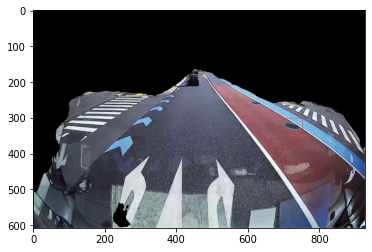

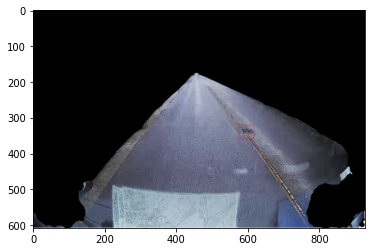

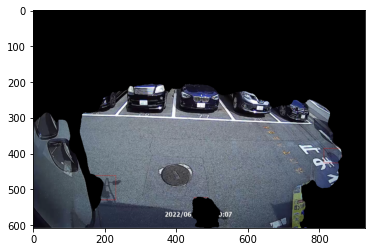

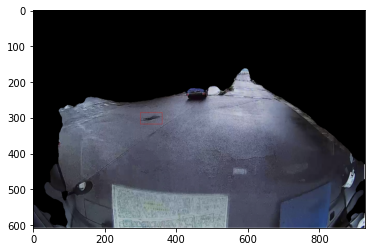

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9329346910>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F93AD758290>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F93297449D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9328AEB850>]


In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image

img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
  plt.imshow(view_image)
  plt.show()

print(to_yolo_imagePIL)

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image

img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
  plt.imshow(view_image)
  plt.show()

print(to_yolo_imagePIL)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/code/static/model/asahuka96hozon.pt')
YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5s_800best.pt')
YOLO_MODEL.to(device)
YOLO_MODEL.conf = 0.25  # NMS confidence threshold
YOLO_MODEL.iou = 0.45  # NMS IoU threshold
YOLO_MODEL.agnostic = False  # NMS class-agnostic
YOLO_MODEL.multi_label = False  # NMS multiple labels per box
YOLO_MODEL.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
YOLO_MODEL.max_det = 1000  # maximum number of detections per image
YOLO_MODEL.amp = False  # Automatic Mixed Precision (AMP) inference
#YOLO_MODEL.device = [2,3]
#YOLO_MODEL.nproc_per_node = 2
model = YOLO_MODEL
print("YOLOv5 🚀 torch 1.10.2+cu102")
input_list = to_yolo_imagePIL

results = model(input_list, size=640)
num = len(input_list)
out_result = {}
out_result["output_"] = []
for k in range(num):
    result = results.pandas().xyxy[k]
    result = result[result["class"]==0]
    out_result["output_"].append(result.to_json(orient="records"))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-7-11 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


YOLOv5 🚀 torch 1.10.2+cu102


In [ ]:
out_result

{'output_': ['[{"xmin":692.8526000977,"ymin":300.1141967773,"xmax":759.9123535156,"ymax":341.3212585449,"confidence":0.9232304692,"class":0,"name":"hole"}]',
  '[{"xmin":568.4530029297,"ymin":317.3227233887,"xmax":621.7864379883,"ymax":360.7565002441,"confidence":0.8397263885,"class":0,"name":"hole"}]',
  '[]',
  '[]']}